# Grad-CAM

Gradient-weighted Class Activation Mapping (Grad-CAM) produces a saliency map using the gradients and values of the final convolutional layer. Grad-CAM is a strict generalization of CAM, the mathematical proof of this is provided in [1]. Grad-CAM still uses global average pooling (GAP) to extract the weightings like CAM, however GAP is not applied to the convolutional layers values, its applied to the convolutional layers gradients instead. To get access to the layers gradients we will use Flax's "perturb" method. This means the "apply" method of the model will now require the perturbations in addition to the models parameters. The perturbations are not used while training, so we can just pass through the default perturbations from initialization. We will only need to provide the valid layer values when calculating the gradient of the convolutional layer.  

For more technical information on the Grad-CAM method see: [1] [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391)


In [31]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jax.numpy as jnp
import flax.linen as nn
from flax.core.frozen_dict import freeze
import jax
from jax import random
from jax import grad
from keras.utils import data_utils

### Load training data
Check if the training data exists. If not, automatically download it.

In [32]:
data_dir = os.path.abspath("./digit-recognizer")
os.makedirs(data_dir, exist_ok=True)
train_data_path = f"{data_dir}/train.zip"
train_data_url = "https://huggingface.co/datasets/ChristianOrr/mnist/resolve/main/train.zip"

if not os.path.exists(train_data_path):
    print("Downloading training data...")
    data_utils.get_file(
        train_data_path, 
        train_data_url, 
        extract=True, 
        cache_dir=data_dir
        )

data_df = pd.read_csv('./digit-recognizer/datasets/train.csv')

In [33]:
val_size = 1000
# Only shuffle training data
np.random.shuffle(data_df[val_size:].values)
m, n = data_df.shape
Y = jnp.array(data_df["label"])
data_df = data_df.drop("label", axis=1)
X = jnp.array(data_df)


X_train = X[val_size:]
X_train = X_train / 255.
Y_train = Y[val_size:]

X_val = X[:val_size]
X_val = X_val / 255.
Y_val = Y[:val_size]

### Define the classification model

In [34]:
class _forward_fn(nn.Module):

    @nn.compact
    def __call__(self, x):
        batch_size = x.shape[0]
        # Unflatten for the convolution layers
        x = x.reshape(batch_size, 28, 28, 1)
        conv_layers = nn.Sequential([
            nn.Conv(features=16, kernel_size=(3, 3), padding="VALID", use_bias=False), jax.nn.relu,
            nn.Conv(features=32, kernel_size=(3, 3), padding="VALID", use_bias=False), jax.nn.relu,  
        ])
        x = conv_layers(x)
        # Use perturb to extract the gradients for the final conv layer
        x = self.perturb("conv_1", x)
        # Save the final convolution layer as an intermediate so 
        # it can be accessed for the cam algorithm
        self.sow("intermediates", "final_conv_layer", x)
        # Flatten
        x = x.reshape((batch_size, -1))
        x = nn.Dense(10)(x)
        return jax.nn.softmax(x)

# Create the model object
forward_fn = _forward_fn()
# Display the model details
dummy_x = X_train[:5]
rng_key = random.PRNGKey(64)
print(forward_fn.tabulate(rng_key, dummy_x))


                              _forward_fn Summary                               
┏━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┓
┃ path     ┃ module   ┃ inputs   ┃ outputs   ┃ perturb… ┃ params    ┃ interme… ┃
┡━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━┩
│          │ _forwar… │ float32… │ float32[… │ conv_1:  │           │ final_c… │
│          │          │          │           │ float32… │           │ -        │
│          │          │          │           │          │           │ float32… │
│          │          │          │           │ 92,160   │           │          │
│          │          │          │           │ (368.6   │           │ 92,160   │
│          │          │          │           │ KB)      │           │ (368.6   │
│          │          │          │           │          │           │ KB)      │
├──────────┼──────────┼──────────┼───────────┼──────────┼───────────┼──────────┤
│ Sequent… │ Sequent… │ flo

### Define the loss function and update method

In [35]:
def one_hot(x, k, dtype=jnp.float32):
    """Create a one-hot encoding of x of size k."""
    return jnp.array(x[..., None] == jnp.arange(k), dtype)

def loss_fn(params, perturbations, X, Y):
    variables = {
        'params': params,
        'perturbations': perturbations
    }
    logits = forward_fn.apply(variables, X)
    one_hot_Y = one_hot(Y, 10)
    loss = -jnp.sum(one_hot_Y * jnp.log(logits)) / m
    return loss

def update_rule(param, update):
    return param - 0.1 * update

def update_params(params, perturbations, alpha, X, Y):
    grads = grad(loss_fn, argnums=0)(params, perturbations, X, Y)
    params = jax.tree_util.tree_map(update_rule, params, grads)
    return params


### Train the model

In [36]:
def get_predictions(logits):
    return jnp.argmax(logits, axis=1)

def get_accuracy(predictions, Y):
    return jnp.mean(predictions == Y)

def gradient_descent(X, Y, batch_size, alpha, epochs):
    dataset_size = len(X)
    steps_per_epoch = dataset_size // batch_size

    rng = jax.random.PRNGKey(42)
    variables = forward_fn.init(rng, X[0: batch_size, :])
    params, perturbations = variables["params"], variables["perturbations"]
    for epoch in range(epochs):
        dataset_step = epoch % steps_per_epoch
        dataset_index = dataset_step * batch_size
        input = X[dataset_index: dataset_index + batch_size, :]
        label = Y[dataset_index: dataset_index + batch_size, ...]
        params = update_params(params, perturbations, alpha, input, label)
        if epoch % 10 == 0:
            print("Iteration: ", epoch)
            logits = forward_fn.apply({'params': params, 'perturbations': perturbations}, input)
            predictions = get_predictions(logits)
            print(get_accuracy(predictions, label))
    return params

In [37]:
params = gradient_descent(X_train, Y_train, 2000, 0.10, 200)

Iteration:  0
0.1315
Iteration:  10
0.731
Iteration:  20
0.78150004
Iteration:  30
0.81750005
Iteration:  40
0.832
Iteration:  50
0.84450006
Iteration:  60
0.85350007
Iteration:  70
0.86300004
Iteration:  80
0.86450005
Iteration:  90
0.8755
Iteration:  100
0.873
Iteration:  110
0.88350004
Iteration:  120
0.87650007
Iteration:  130
0.887
Iteration:  140
0.87950003
Iteration:  150
0.89050007
Iteration:  160
0.8805
Iteration:  170
0.89400005
Iteration:  180
0.88500005
Iteration:  190
0.89550006


### Display predictions and saliency maps

The final convolutional layer values and gradients are required to perform Grad-CAM. To access the convolutional layer it needs to be stored as an intermediate variable in the model definition, then the "mutable='intermediates'" argument is supplied to the model when performing the forward pass. The gradients of the final convolutional layer is extracted by passing the final convolutional layers values as a perturbation parameter to the loss function, then calculating the gradients of the perturbation parameter. Global average pooling is then applied to the convolutional layers gradients to extract the weightings. This is performed by taking the mean of each filter/feature map, this results in a vector of floats with the size of the number of feature maps. The vector is then used as weights for the feature maps. The dot product is taken between the weights and feature maps to provide us with the class activation mapping. 


In [38]:
def make_predictions(X, params, perturbations):
    logits, state = forward_fn.apply({'params': params, 'perturbations': perturbations}, X, mutable='intermediates')
    predictions = get_predictions(logits)
    return predictions, state

def prep_image(image):
    # Normalize the gradient values to be between 0-1
    max_val= np.max(image)
    min_val = np.min(image)
    image = (image - min_val) / (max_val - min_val)
    # Convert the grads to uint8 for displaying
    image = np.uint8(image * 255)
    return image   

def display_prediction(index, params):
    current_image = X_val[None, index]
    rng = jax.random.PRNGKey(42)
    init_variables = forward_fn.init(rng, current_image)
    init_perturbations = init_variables["perturbations"]
    prediction, state = make_predictions(X_val[None, index], params, init_perturbations)

    label = Y_val[index]
    print("Prediction: ", prediction)
    print("Label: ", label)

    display_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(display_image, interpolation='nearest')
    plt.axis('off')
    plt.title("Input Image")
    plt.show()

    # Extract final conv layers values
    final_conv_layer = state["intermediates"]["final_conv_layer"][0][0]
    # Get final conv gradients
    perturbations = freeze({"conv_1": final_conv_layer})
    final_conv_grads = grad(loss_fn, argnums=1)(params, perturbations, current_image, label)
    final_conv_grads = final_conv_grads["conv_1"]
    # Get weights using global average pooling
    weights = jnp.mean(final_conv_grads, axis=(0, 1))
    # Get the weighted sum of all the filters
    cam = jnp.dot(final_conv_layer, weights)
    cam = prep_image(cam)

    plt.gray()
    plt.imshow(cam, interpolation='nearest')
    plt.axis('off')
    plt.title("Saliency Map")
    plt.show()

Prediction:  [1]
Label:  1


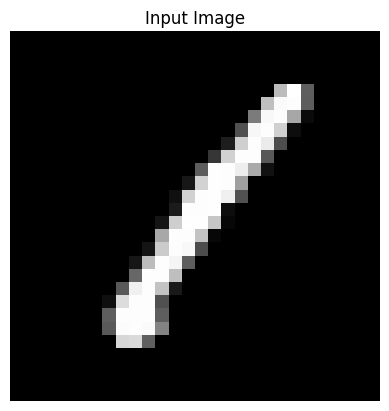

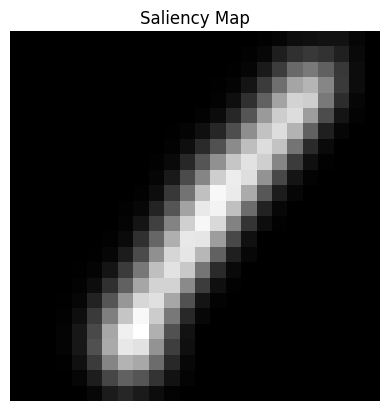

Prediction:  [2]
Label:  4


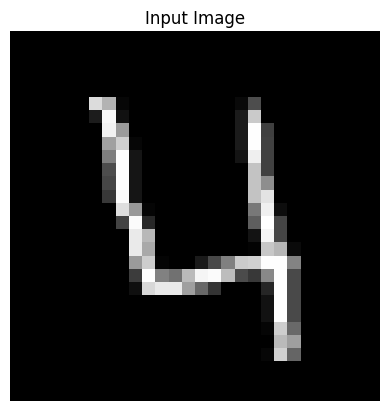

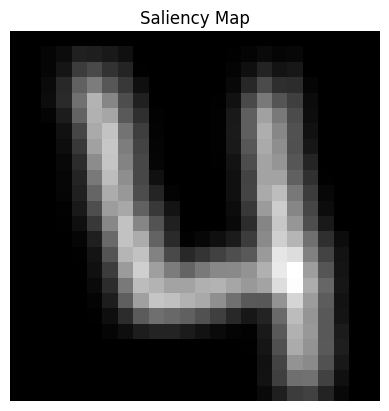

Prediction:  [0]
Label:  0


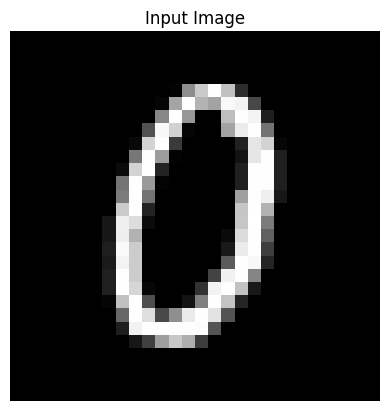

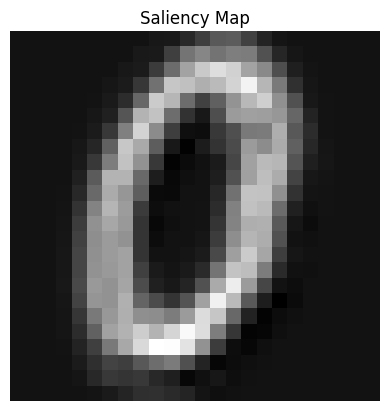

Prediction:  [5]
Label:  5


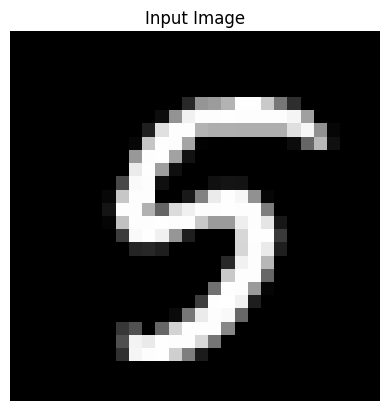

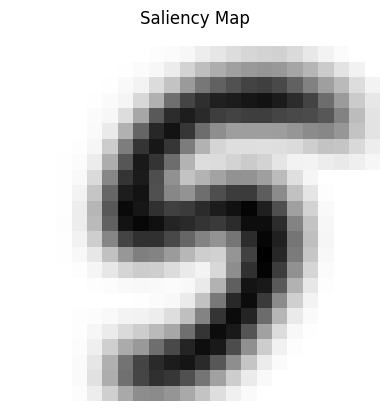

Prediction:  [8]
Label:  8


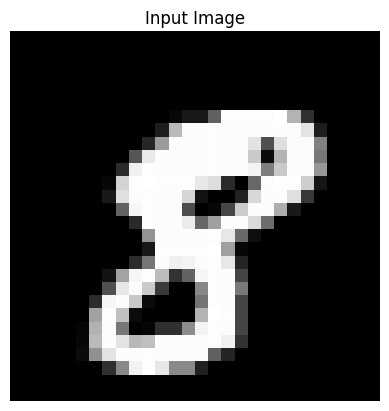

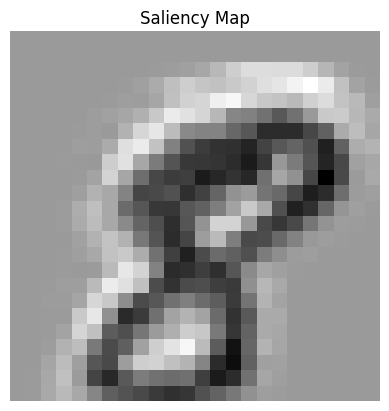

Prediction:  [7]
Label:  7


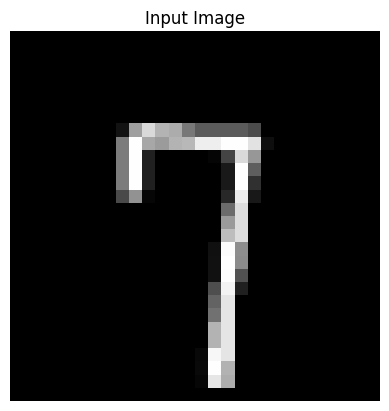

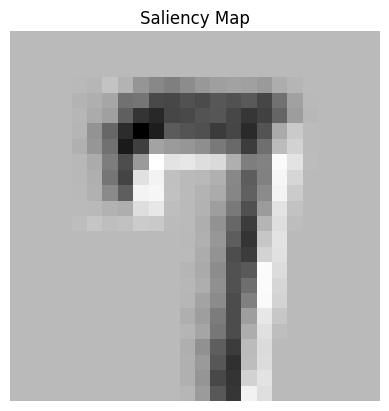

In [39]:
display_prediction(0, params)
display_prediction(3, params)
display_prediction(5, params)
display_prediction(8, params)
display_prediction(10, params)
display_prediction(50, params)